In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sql_connect = sqlite3.connect('starbucks.db')
cursor = sql_connect.cursor()

## Get data from database

In [3]:
portfolio = pd.read_sql_query("SELECT * from portfolio", sql_connect)
profile = pd.read_sql_query("SELECT * from profile", sql_connect)
transcript = pd.read_sql_query("SELECT * from transcript_final", sql_connect)
transcript_training = pd.read_sql_query("SELECT * from transcript_training", sql_connect)
transcript_testing = pd.read_sql_query("SELECT * from transcript_testing", sql_connect)


del transcript['level_0']
del transcript_training['level_0']
del transcript_testing['level_0']

In [4]:
def plot_hist(df, exclude_col=None, include_col=None):
    if not exclude_col and not include_col:
        feature_lst = list(df.columns)        
    if exclude_col:
        feature_lst = set(list(df.columns))-set(exclude_col)
    if include_col:
        feature_lst = include_col
    
    for col in feature_lst:
        if df[col].dtypes == 'object':
            counts = df.groupby(col).size()
            plt.bar(list(counts.index), list(counts.values))
            plt.xlabel(col) 
            plt.show()
        else:
            plt.hist(df[col])
            plt.xlabel(col)
            plt.show()

## Exploratory analysis - Portfolio

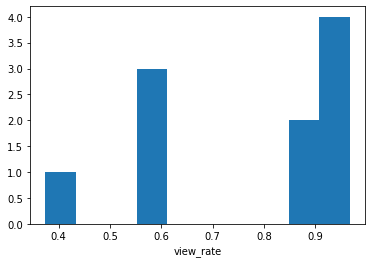

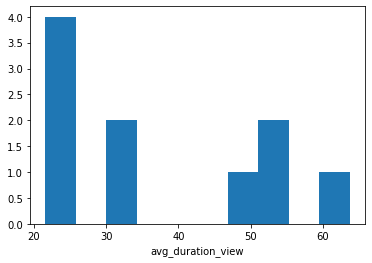

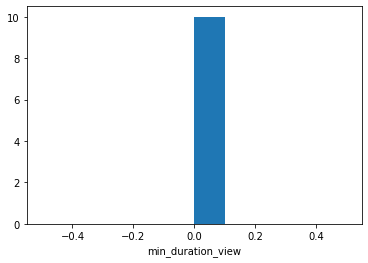

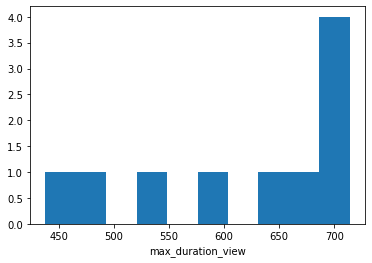

In [5]:
plot_hist(portfolio, include_col=['view_rate', 'avg_duration_view', 'min_duration_view', 'max_duration_view'])

In [6]:
### remove min_duration_view
portfolio.drop(columns='min_duration_view', inplace=True)

### Correlation between features

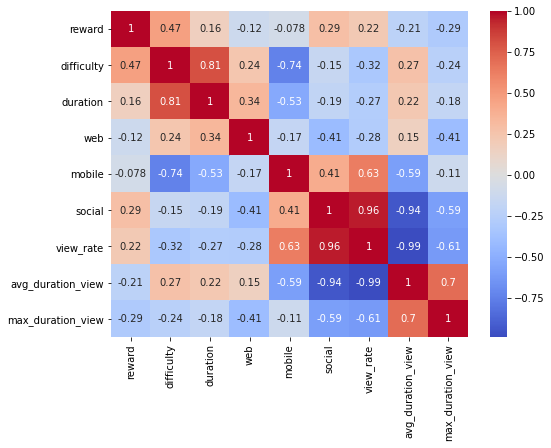

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
corr = portfolio.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        cmap="coolwarm");

`duration`, `difficulty` and `mobile` are highly correlated with each other => keep `duration` only. <br> 
`social`, `view_rate`, and `avg_duration_view` are highly correlated with each other  => keep `social` only. <br>

In [8]:
portfolio.drop(columns=['difficulty', 'mobile', 'view_rate', 'avg_duration_view'], inplace=True)

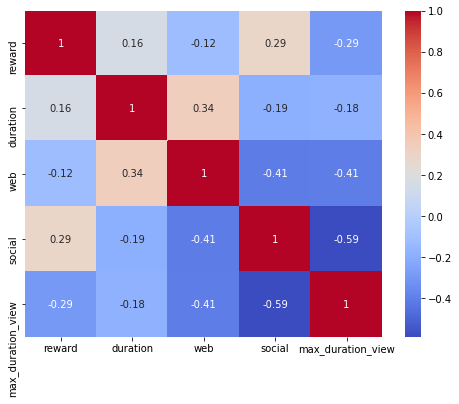

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
corr = portfolio.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        cmap="coolwarm");

## Exploratory analysis - Profile

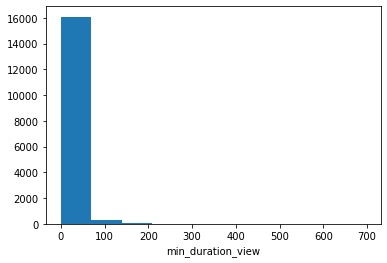

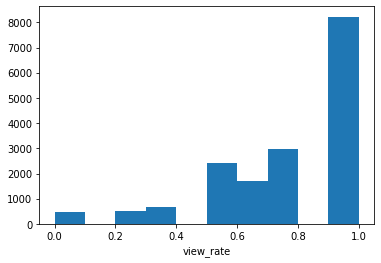

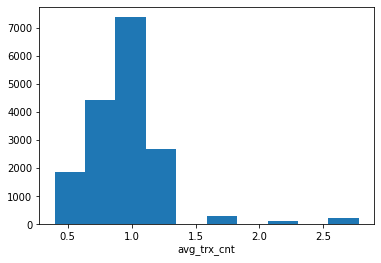

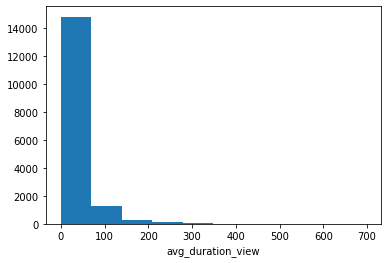

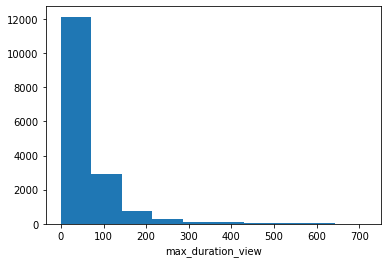

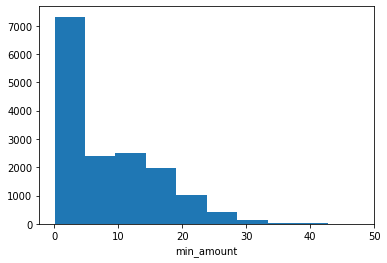

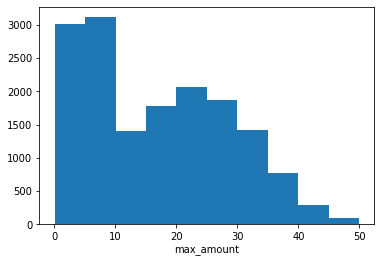

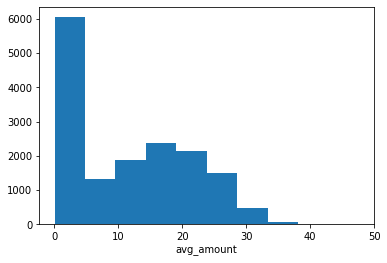

In [10]:
plot_hist(profile, exclude_col=['id', 'gender', 'age', 'became_member_on', 'income'])

All feature distributions are skewed

### Transforming skewed data using log transformation

In [11]:
view_amount_features = ['max_duration_view', 'view_rate', 'max_amount', 'min_duration_view', 'min_amount',\
                       'avg_amount', 'avg_trx_cnt', 'avg_duration_view']
profile_transformed = np.log(profile[view_amount_features]+1)

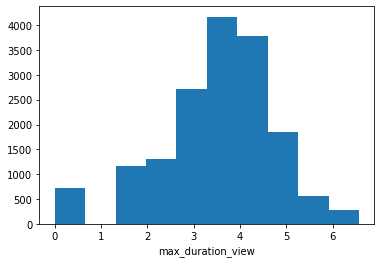

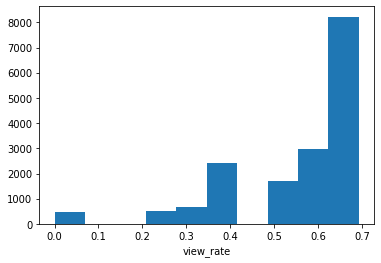

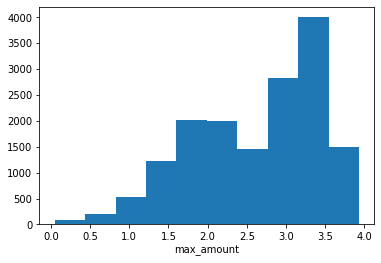

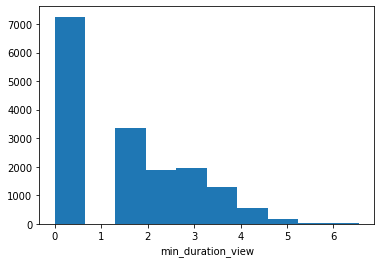

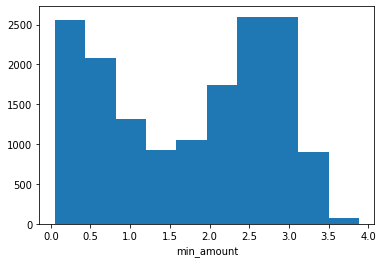

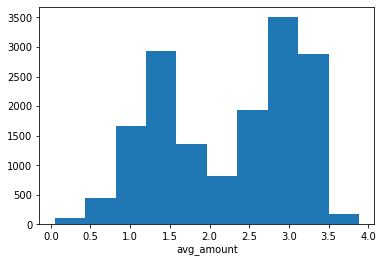

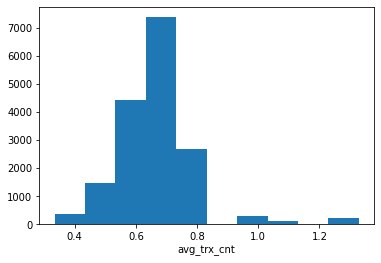

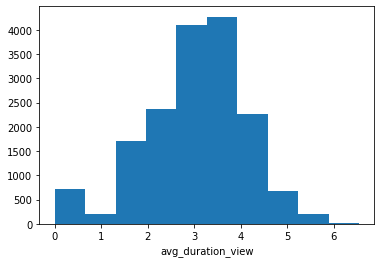

In [12]:
plot_hist(profile_transformed)

In [13]:
profile = pd.concat([profile[['id', 'gender', 'age', 'became_member_on', 'income']],profile_transformed], axis=1)

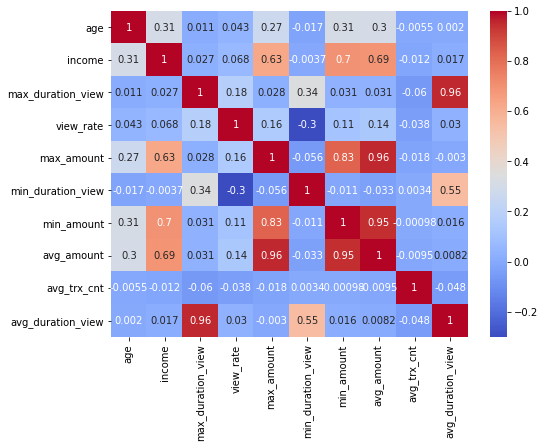

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
corr = profile.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        cmap="coolwarm");

`income`, `min_amount`, `avg_amount` and `max_amount` are highly correlated with each other => keep `max_amount` only. <br> 
`avg_duration_view` and `max_duration_view` are highly correlated with each other  => keep `max_duration_view` only. <br>

In [15]:
profile.drop(columns=['income', 'min_amount', 'avg_amount', 'avg_duration_view'], inplace=True)

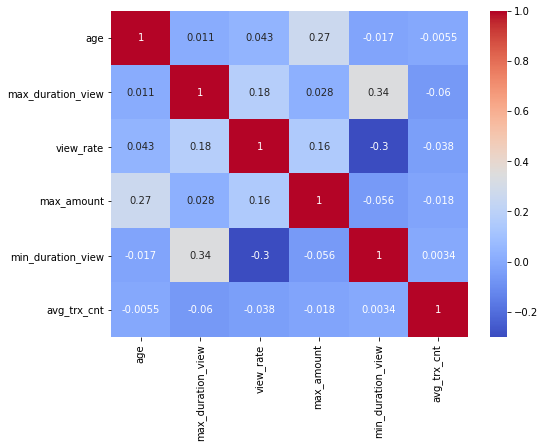

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
corr = profile.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        cmap="coolwarm");

## Exploratory analysis - Transcript

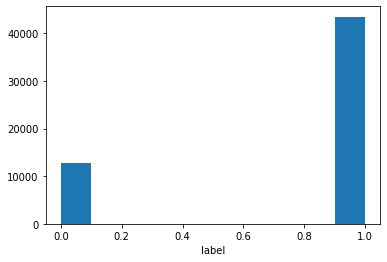

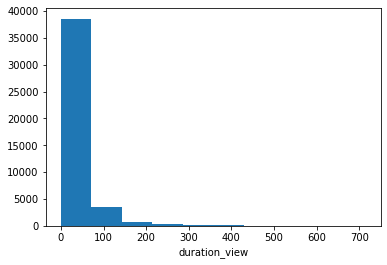

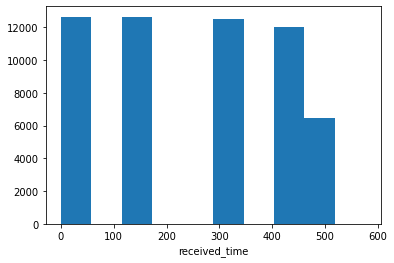

In [17]:
plot_hist(transcript_training, exclude_col=['index', 'person', 'offer_id', 'training_label'])

Duration view is skewed

### Transforming skewed data using log transformation on both testing and training

In [18]:
transcript_training['duration_view'] = np.log(transcript_training['duration_view']+1)
transcript_testing['duration_view'] = np.log(transcript_testing['duration_view']+1)

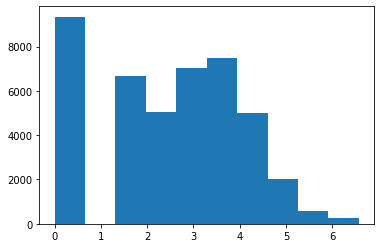

In [19]:
plt.hist(transcript_training['duration_view'].dropna());

## Normalize Portfolio, Profile, and Transcript Data Table

### Combine training and testing

In [20]:
transcript_comb = pd.concat([transcript_training, transcript_testing], axis=0)

In [21]:
trans_port_df = pd.merge(transcript_comb, portfolio, how='inner', left_on='offer_id', right_on='id')
trans_port_df.drop(columns=['index', 'id'], inplace=True)
trans_port_df.rename({'max_duration_view':'max_duration_view_portfolio'}, axis=1, inplace=True)
assert trans_port_df.shape[0] == transcript_comb.shape[0], "rows do not match with original data"

In [22]:
trans_port_profile_df = pd.merge(trans_port_df, profile, how='inner', left_on='person', right_on='id')
trans_port_profile_df.drop(columns=['id'], inplace=True)
trans_port_profile_df.rename({'max_duration_view':'max_duration_view_profile'}, axis=1, inplace=True)
assert trans_port_profile_df.shape[0] == transcript_comb.shape[0], "rows do not match with original data"

In [23]:
missing_col = list(trans_port_profile_df.isnull().sum()[trans_port_profile_df.isnull().sum() > 0].index)

for col in missing_col:
    if trans_port_profile_df[col].dtypes == 'object':
        # Using mode to impute the missing categorical values
        trans_port_profile_df.loc[trans_port_profile_df.loc[:,col].isnull(),col]= \
        trans_port_profile_df[col].value_counts().sort_values(ascending=False).index[0]
    else:
        # Using mean to impute the missing numerical values
        trans_port_profile_df.loc[trans_port_profile_df.loc[:,col].isnull(),col]=trans_port_profile_df.loc[:,col].mean()

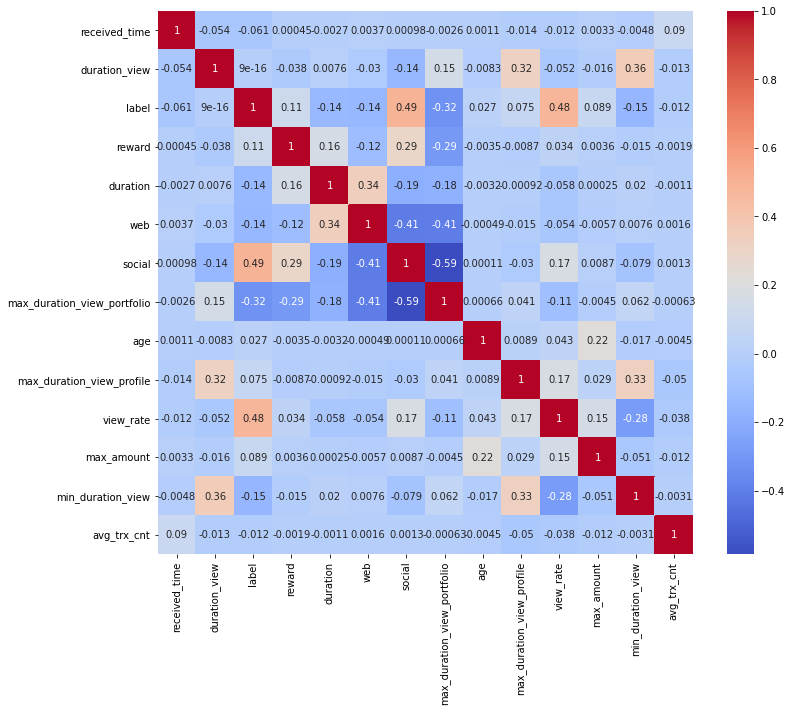

In [24]:
df = trans_port_profile_df.drop(columns=['training_label'])

fig, ax = plt.subplots(figsize=(12,10))
corr = df.corr()
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        cmap="coolwarm");

## Save data frame to database

In [25]:
trans_port_profile_df.to_sql('combine_df', sql_connect, if_exists='replace')